In [73]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import sqlite3
import time

# データベースの設定
db_file = 'hotels.db'
table_name = 'hotels'

# データベースにテーブルを作成する関数
def create_table():
    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()
    cursor.execute(f'DROP TABLE IF EXISTS {table_name}')
    cursor.execute(f'''
        CREATE TABLE {table_name} (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            hotel_name TEXT,
            detail_page_url TEXT,
            access_info TEXT,
            price_info TEXT,
            unit_price TEXT,
            hotel_rating TEXT,
            review_count TEXT,
            region TEXT
        )
    ''')
    conn.commit()
    conn.close()

# データベースにデータを挿入する関数
def insert_data(hotels):
    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()
    for hotel in hotels:
        cursor.execute(f'''
            INSERT INTO {table_name} (hotel_name, detail_page_url, access_info, price_info, unit_price, hotel_rating, review_count, region)
            VALUES (?, ?, ?, ?, ?, ?, ?, ?)
        ''', (hotel["ホテル名"], hotel["詳細ページURL"], hotel["アクセス情報"], hotel["価格情報"], hotel["一人あたり価格"], hotel["ホテルの評価"], hotel["レビュー数"], hotel["地域"]))
    conn.commit()
    conn.close()

base_url = "https://www.jalan.net/ikisaki/map/tokyo/"
response = requests.get(base_url)

soup = BeautifulSoup(response.content, "html.parser")
meta_tag = soup.find("meta", {"charset": True})

if meta_tag and meta_tag.get("charset"):
    response.encoding = meta_tag.get("charset")
else:
    response.encoding = response.apparent_encoding

soup = BeautifulSoup(response.text, "html.parser")

map_right_inner_div = soup.find("div", class_="map-right-inner")
if map_right_inner_div:
    a_tags = map_right_inner_div.find_all("a", class_="sub")
    print(f"発見した a タグの数: {len(a_tags)}")
else:
    print("対象の div が見つかりませんでした。")
    a_tags = []

urls_with_titles = [(urljoin(base_url, a['href']), a.get_text(strip=True)) for a in a_tags if 'href' in a.attrs]

def fix_encoding(text):
    try:
        return text.encode('latin1').decode('utf-8')
    except (UnicodeEncodeError, UnicodeDecodeError):
        return text  # 修正できない場合そのまま返す

def get_hotel_data_from_page(url, region):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")
    meta_tag = soup.find("meta", {"charset": True})
    if meta_tag and meta_tag.get("charset"):
        response.encoding = meta_tag.get("charset")
    else:
        response.encoding = response.apparent_encoding
    soup = BeautifulSoup(response.text, "html.parser")

    hotel_divs = soup.find_all("div", class_="p-yadoCassette__body p-searchResultItem__body")
    hotels = []

    for hotel_div in hotel_divs:
        # ホテル名
        h2_tag = hotel_div.find("h2", class_="p-searchResultItem__facilityName")
        raw_hotel_name = h2_tag.get_text(strip=True) if h2_tag else "ホテル名なし"
        hotel_name = fix_encoding(raw_hotel_name)

        # 詳細ページURL
        a_tag = hotel_div.find("a", class_="jlnpc-yadoCassette__link s16_00 fb")
        detail_url = a_tag['data-href'] if a_tag and 'data-href' in a_tag.attrs else "URLなし"

        # アクセス情報
        access_tag = hotel_div.find("dd", class_="p-searchResultItem__accessValue")
        access_info = access_tag.get_text(strip=True) if access_tag else "アクセス情報なし"

        # 価格情報
        price_tag = hotel_div.find("span", class_="p-searchResultItem__lowestPriceValue")
        price_info = price_tag.get_text(strip=True) if price_tag else "価格情報なし"

        # 一人あたり価格
        unit_price_tag = hotel_div.find("span", class_="p-searchResultItem__lowestUnitPrice")
        unit_price_info = unit_price_tag.get_text(strip=True) if unit_price_tag else "一人あたり価格情報なし"

        # ホテルの評価
        rating_tag = hotel_div.find("span", class_="p-searchResultItem__summaryaverage-num")
        rating_info = rating_tag.get_text(strip=True) if rating_tag else "評価なし"

        # レビュー数
        review_count_tag = hotel_div.find("span", class_="p-searchResultItem__summarykuchikomi__totalNumber")
        review_count_info = review_count_tag.get_text(strip=True) if review_count_tag else "レビュー数なし"

        hotels.append({
            "ホテル名": hotel_name,
            "詳細ページURL": detail_url,
            "アクセス情報": access_info,
            "価格情報": price_info,
            "一人あたり価格": unit_price_info,
            "ホテルの評価": rating_info,
            "レビュー数": review_count_info,
            "地域": region
        })
    
    return hotels, soup

def get_next_page_url(current_url, page_number):
    next_url = f"{current_url}page{page_number}.html"
    return next_url

# テーブルを作成
create_table()

all_hotels = 0
for i, (url, region) in enumerate(urls_with_titles, 1):
    print(f"URL {i}: {url} (地域: {region})")
    current_url = url
    page_number = 2
    url_hotels_count = 0
    previous_page_title = None

    while current_url:
        print(f"現在のページ: {current_url}")
        hotels, soup = get_hotel_data_from_page(current_url, region)
        
        # ページタイトルが前のページと同じかどうかを確認
        current_page_title = soup.title.string if soup.title else None
        if current_page_title == previous_page_title:
            print("同じタイトルのページが検出されました。前者のページのみ抽出します。")
            break

        # ホテル情報を抽出
        insert_data(hotels)
        url_hotels_count += len(hotels)
        all_hotels += len(hotels)

        previous_page_title = current_page_title
        current_url = get_next_page_url(url, page_number)
        page_number += 1
        time.sleep(1)
    print(f"URL {i} で取得したホテルの数: {url_hotels_count}")

print(f"総取得ホテル数: {all_hotels}")

発見した a タグの数: 13
URL 1: https://www.jalan.net/130000/LRG_137100/ (地域: お台場・汐留・新橋・品川)
現在のページ: https://www.jalan.net/130000/LRG_137100/
現在のページ: https://www.jalan.net/130000/LRG_137100/page2.html
現在のページ: https://www.jalan.net/130000/LRG_137100/page3.html
現在のページ: https://www.jalan.net/130000/LRG_137100/page4.html
現在のページ: https://www.jalan.net/130000/LRG_137100/page5.html
同じタイトルのページが検出されました。前者のページのみ抽出します。
URL 1 で取得したホテルの数: 123
URL 2: https://www.jalan.net/130000/LRG_138000/ (地域: 新宿・中野・杉並・吉祥寺)
現在のページ: https://www.jalan.net/130000/LRG_138000/
現在のページ: https://www.jalan.net/130000/LRG_138000/page2.html
現在のページ: https://www.jalan.net/130000/LRG_138000/page3.html
現在のページ: https://www.jalan.net/130000/LRG_138000/page4.html
現在のページ: https://www.jalan.net/130000/LRG_138000/page5.html
現在のページ: https://www.jalan.net/130000/LRG_138000/page6.html
同じタイトルのページが検出されました。前者のページのみ抽出します。
URL 2 で取得したホテルの数: 147
URL 3: https://www.jalan.net/130000/LRG_136200/ (地域: 銀座・日本橋・東京駅周辺)
現在のページ: https://www.jalan.net/130000/LRG_1

全データによる地域ごとの平均値:
                  region  hotel_rating    unit_price
0           お台場・汐留・新橋・品川      4.205941   5604.059322
1   お茶の水・湯島・九段・後楽園・東京ドーム      4.008065   3182.062500
2               上野・浅草・両国      4.025000   6688.286164
3               伊豆七島・小笠原      4.158333   8840.195652
4        八王子・立川・町田・府中・調布      4.010127   4025.828947
5           六本木・麻布・赤坂・青山      3.957447  12316.700000
6           新宿・中野・杉並・吉祥寺      4.045263   6344.641667
7            池袋・目白・板橋・赤羽      4.007477   3570.184932
8              渋谷・目黒・世田谷      4.032692   6135.737705
9              葛飾・江戸川・江東      4.024074   3041.405797
10            蒲田・大森・羽田周辺      3.850877   4678.678322
11          銀座・日本橋・東京駅周辺      4.041279  10651.173228
12                青梅・奥多摩      4.186667  12280.366667

全データの相関行列:
              hotel_rating  unit_price
hotel_rating       1.00000     0.19291
unit_price         0.19291     1.00000


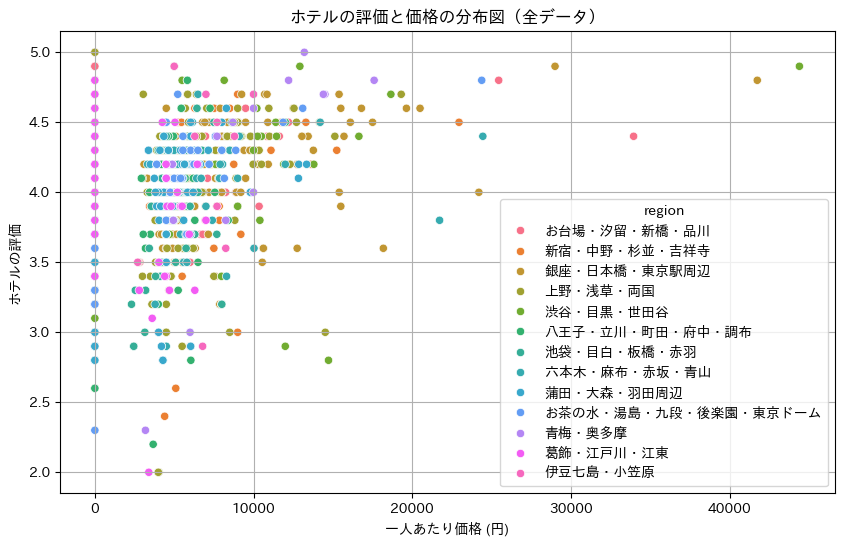

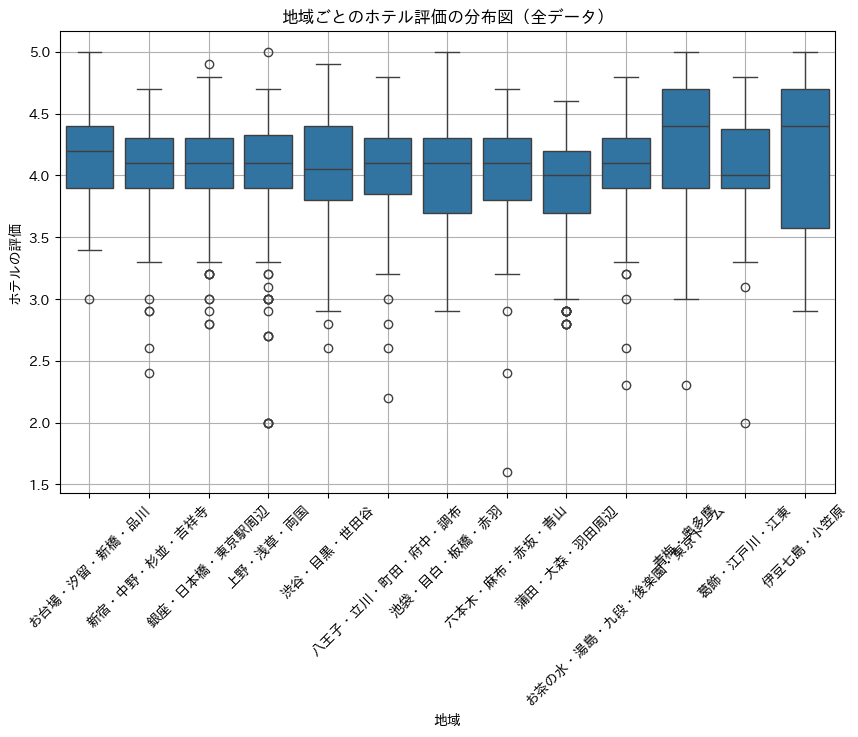

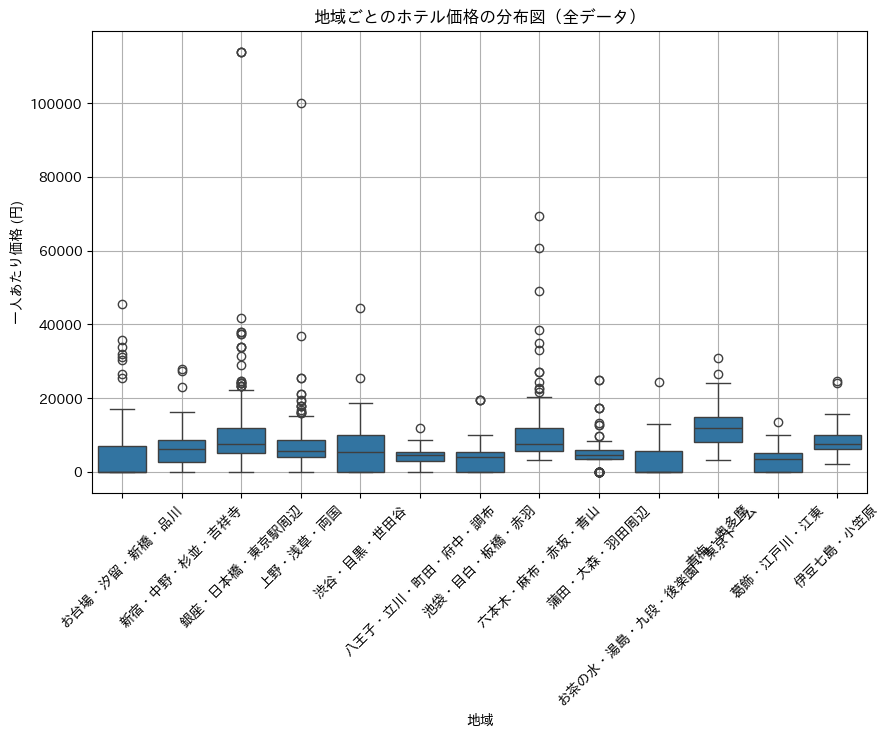


フィルタリングしたデータによる地域ごとの平均値:
       region  hotel_rating unit_price
0    伊豆七島・小笠原      4.158333        NaN
1   葛飾・江戸川・江東      4.024074        NaN
2  蒲田・大森・羽田周辺      3.850877        NaN

フィルタリングデータの相関行列:
              hotel_rating  unit_price
hotel_rating           1.0         NaN
unit_price             NaN         NaN


/var/folders/m0/xd8x8xps2j32jlry927rzzph0000gn/T/ipykernel_57079/2899671519.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['unit_price'] = df['unit_price'].apply(lambda x: extract_numeric_part(x) if isinstance(x, str) else None)
/var/folders/m0/xd8x8xps2j32jlry927rzzph0000gn/T/ipykernel_57079/2899671519.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hotel_rating'] = df['hotel_rating'].apply(lambda x: float(x) if x != '評価なし' else None)


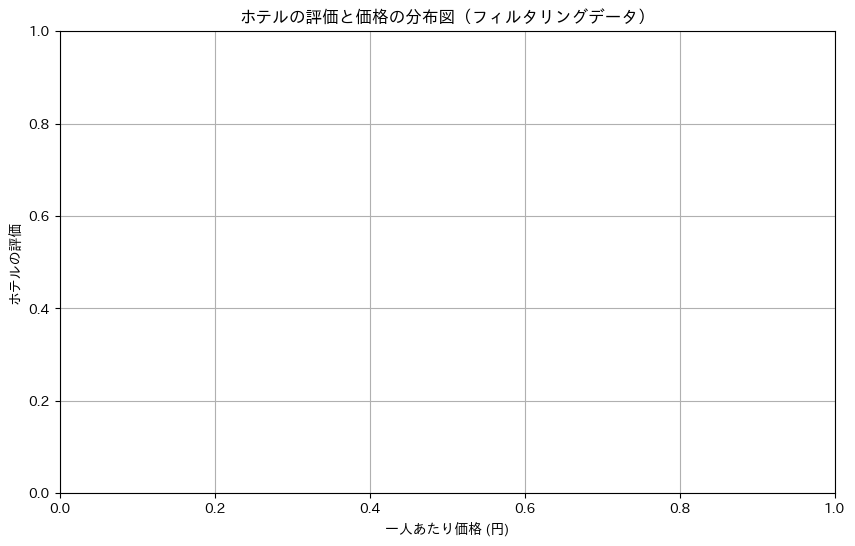

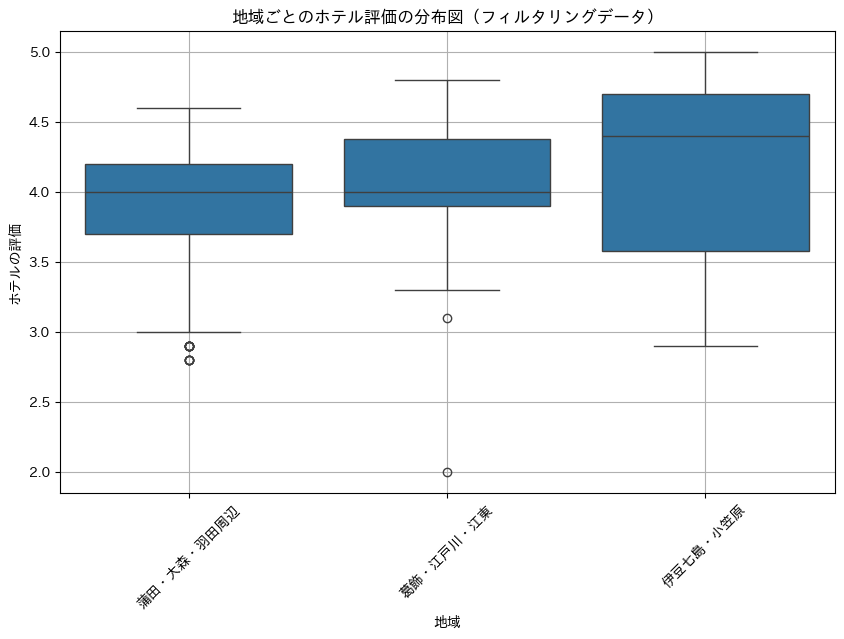

ValueError: List of boxplot statistics and `positions` values must have same the length

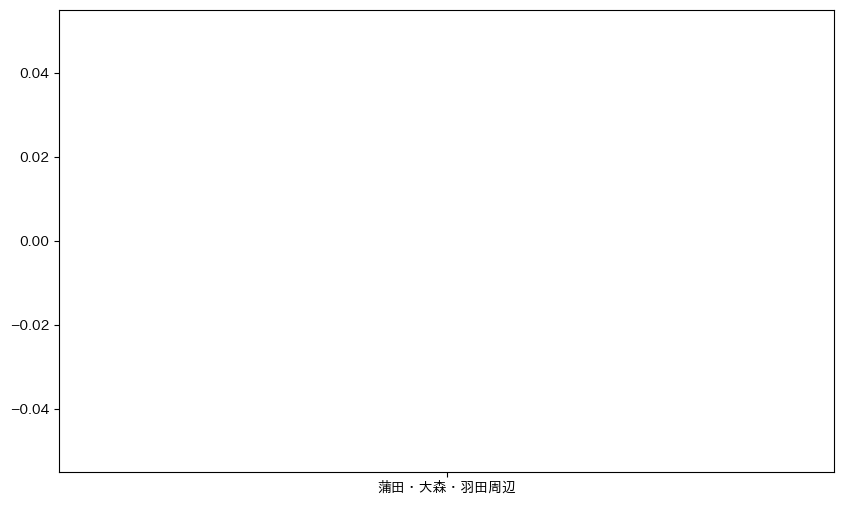